# TUIA - Computer Vision - Trabajo Practico Final

Alumno: Cesar Julian Donnarumma.

Año: 2024.

## Ejercicio 02: Dataset Personal

A partir de las imágenes y anotaciones generadas en el Ejercicio 1, el alumno deberá generar su propio conjunto de datos, aumentarlo, y generar las particiones (entrenamiento, validación, prueba) para trabajar en los entrenamientos.

Realizar un script que:

* Valide las anotaciones, verificando que ningún bounding box exceda los límites de la imagen. En caso de hallar anomalías, separar los pares de archivos en una carpeta llamada “label_errors”.

* Unifique las anotaciones en un formato Yolo único (ya que pueden estar en
versiones de 5 valores o de 9 valores por línea, según la versión de Yolo), para lo cual se deben reescribir los .txt en caso que sea necesario. De cualquier manera, las evaluaciones sobre las detecciones que realice el modelo se evaluarán a partir del formato YoloV5 propuesto, donde debe existir un archivo .txt por cada archivo de image con el mismo nombre, donde cada línea del archivo corresponda a la detección de un objeto. Cada línea, deberá contener los siguientes datos: id_clase, x_centro, y_centro, ancho, alto, certeza.

Explicar:

● Cantidades de imágenes de cada split.

● Los tipos de aumentación utilizados y por qué aplicó determinadas herramientas.

● La composición del dataset en términos de balanceo de clases. Graficar.

● Utilizar la herramienta FiftyOne para visualizar el nuevo dataset generado.

### Importaciones:

In [1]:
%matplotlib inline

In [2]:
!pip install fiftyone

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 74.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.6/133.6 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.5/192.5 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.6/89.6 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.7/74.7 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 942.9/942.9 kB 53.7 MB/s eta 0:00:

In [3]:
from google.colab import drive
import os
import shutil
from sklearn.model_selection import train_test_split
import copy
import albumentations as A
import cv2
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import random
import fiftyone as fo

Montamos el Drive para poder trabajar con el dataset

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


### Validacion de anotaciones:

Se verificara:

* Que ningun punto de los bounding boxes quede fuera de la imagen.

* Que ningun .txt contenga una clase que no corresponda a una carta.

Y en caso de que ocurra alguna de las situaciones se movera la imagen y el txt a una carpeta llamada label_errors.

In [ ]:
# Lista de clases utilizadas para el etiquetado
clases = '1O 1C 1E 1B 2O 2C 2E 2B 3O 3C 3E 3B 4O 4C 4E 4B 5O 5C 5E 5B 6O 6C 6E 6B 7O 7C 7E 7B 8O 8C 8E 8B 9O 9C 9E 9B 10O 10C 10E 10B 11O 11C 11E 11B 12O 12C 12E 12B J'

# Diccionario que mapea indices del etiquetado yolo realizado a clases
diccionario_clases = {indice: clase for indice, clase in enumerate(clases.split())}

In [ ]:
# Ruta al dataset
ruta_dataset = '/content/drive/MyDrive/TUIA_Computer_Vision/TP_02/nuevo_dataset_etiquetado'

# Especifica la ruta de la carpeta que deseas crear
ruta_label_errors = '/content/drive/MyDrive/TUIA_Computer_Vision/TP_02/label_errors'

# Crear la carpeta anterior si no existe
os.makedirs(ruta_label_errors, exist_ok=True)

# Lista con los nombres de las imagenes
imagenes = [f for f in os.listdir(ruta_dataset) if (not os.path.isdir(os.path.join(ruta_dataset, f))) and (os.path.splitext(f)[1].lower() != '.txt')]

for imagen in set(imagenes):

  # Construimos la ruta a la imagen en cuestion
  ruta_imagen = os.path.join(ruta_dataset, imagen)
  # Construimos la ruta al .txt correspondiente a la imagen
  ruta_txt = ruta_imagen[ : ruta_imagen.rfind('.') ] + '.txt'

  # Abrimos el archivo y nos quedamos con cada linea (anotacion de objeto)
  with open(ruta_txt, 'r') as file:
      lineas = file.readlines()

  # Recorremos cada linea
  for linea in lineas:

    # Extraemos en una lista cada una de sus componentes
    items_linea = linea.strip().split()

    # Extraemos las coordenadas del bb en formato yolo
    clase = int(items_linea[0])
    x_center = float(items_linea[1])
    y_center = float(items_linea[2])
    ancho = float(items_linea[3])
    alto = float(items_linea[4])

    # Generamos las esquinas del bb para comprobar si se sale de los limites de la imagen
    x1 = x_center - (ancho/2)
    x2 = x_center + (ancho/2)
    y1 = y_center - (alto/2)
    y2 = y_center + (alto/2)

    # Hacemos las comprobaciones, si alguna de las condiciones se cumple
    if (x1 < 0) or (x2 > 1) or (y1 < 0) or (y2 > 1) or (clase < 0) or (clase > 48):
      # Informacion de
      print('------'*4)
      print(f"Imagen: '{imagen}' movida")
      print('Primer etiqueta en conflicto:')
      print(f"x1={x1}\nx2={x2}\ny1={y1}\ny2={y2}\nclase={clase}({diccionario_clases.get(clase, 'No existe')})")
      print('------'*4)
      # Movemos la imagen
      shutil.move(ruta_imagen, os.path.join(ruta_label_errors, imagen))
      # Movemos el txt
      shutil.move(ruta_txt, os.path.join(ruta_label_errors, imagen[ : imagen.rfind('.') ] + '.txt'))
      break

------------------------
Imagen: '653.png' movida
Primer etiqueta en conflicto:
x1=0.7096775
x2=1.0000005
y1=0.31875
y2=0.578906
clase=0(1O)
------------------------
------------------------
Imagen: '1062.png' movida
Primer etiqueta en conflicto:
x1=0.322
x2=0.61025
y1=0.7613335
y2=1.0000005
clase=17(5C)
------------------------
------------------------
Imagen: '817.png' movida
Primer etiqueta en conflicto:
x1=0.6986114999999999
x2=1.0000005
y1=0.49218749999999994
y2=0.7515624999999999
clase=44(12O)
------------------------
------------------------
Imagen: '1216.png' movida
Primer etiqueta en conflicto:
x1=0.5770835
x2=1.0000005
y1=0.6796880000000001
y2=1.0
clase=8(3O)
------------------------
------------------------
Imagen: '601.jpeg' movida
Primer etiqueta en conflicto:
x1=0.2711115
x2=1.0000005
y1=0.3187495
y2=0.7081245
clase=45(12C)
------------------------
------------------------
Imagen: '019.jpg' movida
Primer etiqueta en conflicto:
x1=0.5890655
x2=1.0000005
y1=0.2395835
y2=0.4

* Podemos ver arriba que imagenes se movieron y si observamos los valores de las coordenadas de los bb podemos entender por que se movieron.

In [ ]:
print(f'Cantidad de imagenes movidas: {int(len(os.listdir(ruta_label_errors))/2)}')

Cantidad de imagenes movidas: 66


* En total se movieron 66 imagenes cuyo bb estaba fuera de la imagen (en general por muy poco)

### Unificacion de anotaciones en formato Yolo unico:

* En cuanto a esta parte de la consigna no es necesario hacerla ya que las anotaciones de todas las imagenes se volvieron a realizar bajo el mismo criterio, por lo tanto todas las imagenes contienen su respectiva anotacion en version de 5 valores por linea.

### Particion de los datos en Train y Validacion:

Creacion de los directorios donde estaran guardados los datos particionados

In [ ]:
# Ruta del dataset particionado
ruta_datos_particionados = os.path.join('/content/drive/MyDrive/TUIA_Computer_Vision/TP_02', 'data')

# Crear las carpetas necesarias
def create_dirs(ruta_datos_particionados):
    dirs = [
        os.path.join(ruta_datos_particionados, "images/train"),
        os.path.join(ruta_datos_particionados, "images/val"),
        os.path.join(ruta_datos_particionados, "images/test"),
        os.path.join(ruta_datos_particionados, "labels/train"),
        os.path.join(ruta_datos_particionados, "labels/val"),
        os.path.join(ruta_datos_particionados, "labels/test"),
    ]

    for d in dirs:
        os.makedirs(d, exist_ok=True)

create_dirs(ruta_datos_particionados)

Particion del dataset en si

In [ ]:
# Nos quedamos con todas las imagenes de donde esta el dataset
imagenes = [f for f in os.listdir(ruta_dataset) if (not os.path.isdir(os.path.join(ruta_dataset, f))) and (os.path.splitext(f)[1].lower() != '.txt')]

# Dividir en train, val, test (70%, 15%, 15%)
train_img, temp_img = train_test_split(imagenes, test_size=0.3, random_state=42)
val_img, test_img = train_test_split(temp_img, test_size=0.5, random_state=42)

# Funcion para mover imagenes y anotaciones
def mover_imagenes(files, subset, base_dir):

    # De cada imagen del subconjunto
    for file in files:
        # Generamos la ruta fuente y destino
        image_src = os.path.join(ruta_dataset, file)
        image_dst = os.path.join(base_dir, f"images/{subset}", file)
        # Movemos la imagen
        shutil.move(image_src, image_dst)

        # Mover la etiqueta correspondiente si existe
        label_file = os.path.splitext(file)[0] + ".txt"
        label_src = os.path.join(ruta_dataset, label_file)
        if os.path.exists(label_src):
            label_dst = os.path.join(base_dir, f"labels/{subset}", label_file)
            shutil.move(label_src, label_dst)

# Mover los archivos a las carpetas correspondientes
mover_imagenes(train_img, "train", ruta_datos_particionados)
mover_imagenes(val_img, "val", ruta_datos_particionados)
mover_imagenes(test_img, "test", ruta_datos_particionados)

* Ahora ya tenemos creada un directorio 'data' que por dentro tiene una estructura como la que necesitamos con las imagenes y los labels de cada subconjunto por separado.

In [ ]:
anotaciones = ['images', 'labels']
conjuntos = ['train', 'val', 'test']

for conjunto in conjuntos:
  print('-----'*20)
  print(f'{conjunto}:')
  for anotacion in anotaciones:
    path = os.path.join(ruta_datos_particionados, anotacion, conjunto)
    archivos = os.listdir(path)
    print(f'{path}: {len(archivos)} archivos')
  print('-----'*20)

----------------------------------------------------------------------------------------------------
train:
/content/drive/MyDrive/TUIA_Computer_Vision/TP_02/data/images/train: 957 archivos
/content/drive/MyDrive/TUIA_Computer_Vision/TP_02/data/labels/train: 957 archivos
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
val:
/content/drive/MyDrive/TUIA_Computer_Vision/TP_02/data/images/val: 205 archivos
/content/drive/MyDrive/TUIA_Computer_Vision/TP_02/data/labels/val: 205 archivos
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
test:
/content/drive/MyDrive/TUIA_Computer_Vision/TP_02/data/images/test: 206 archivos
/content/drive/MyDrive/TUIA_Computer_Vision/TP_02/data/labels/test: 206 

* Arriba se puede ver la cantidad de archivos que tiene cada subconjunto.

In [ ]:
# Crear el archivo dataset.yaml
yaml_content = f"""
path: {ruta_datos_particionados}
train: images/train
val: images/val
test: images/test

nc: {len(clases.split())}
names: {clases.split()}
"""

yaml_path = os.path.join(ruta_datos_particionados, "dataset.yaml")
with open(yaml_path, "w") as f:
    f.write(yaml_content)

### Aumentacion:

#### Pipeline con las transformaciones

* En primer lugar vamos a calcular todas las areas de los bb de train ya existentes, el minimo valor de area que tenemos hasta ahora sera el min_area que le permitiremos a los bb en nuestro pipeline.

In [ ]:
# Ruta a los labels de Train
ruta_labels_train = '/content/drive/MyDrive/TUIA_Computer_Vision/TP_02/data/labels/train'

# Lista con los nombres de las imagenes
labels_train = [f for f in os.listdir(ruta_labels_train) if os.path.splitext(f)[1] == '.txt']

In [ ]:
areas = []

for label in labels_train:

  # Abrimos el archivo y nos quedamos con cada linea (anotacion de objeto)
  with open( os.path.join(ruta_labels_train, label) , 'r') as file:
      lineas = file.readlines()

  # Recorremos cada linea
  for linea in lineas:

    # Nos quedamos con ancho y alto
    items_linea = linea.strip().split()
    ancho = float(items_linea[3])
    alto = float(items_linea[4])

    # Calculamos area de bb
    area = ancho*alto

    # Agregamos a lista donde estaran todas las areas
    areas.append(area)

# Metemos todo en una tabla de pandas
tabla_areas = pd.DataFrame(data=areas, columns=['area_bb'])

# Vemos algunas medidas de resumen
tabla_areas.describe()

area_minima = tabla_areas.min()
area_minima

area_bb    0.008307
dtype: float64

* Para seleccionar las transformaciones a utilizar se leyo en la documentacion oficial de Albumentations y se probaron cada una en https://demo.albumentations.ai/.

In [ ]:
# Creamos el pipeline de transformaciones
transform = A.Compose([
    # Transormaciones a nivel pixel
  A.OneOf([ # Cuando usamos OneOf ponemos una p de OneOf de que se entre en este bloque y las p de cada uno de los elementos del interior en 1 asi el que se elige se ejecuta si o si
      A.CLAHE(always_apply=False, p=1.0, clip_limit=(1, 45), tile_grid_size=(47, 52)), # Aplica ecualizacion de histograma adaptativo limitado a la imagen de entrada
      A.RandomBrightnessContrast(always_apply=False, p=1.0, brightness_limit=(-0.2, 0.48), contrast_limit=(-0.08, 0.51), brightness_by_max=True) # Ajusta aleatoriamente el brillo y el contraste
  ], p=0.5),
  A.OneOf([
      A.Blur(always_apply=False, p=1.0, blur_limit=(3, 50)), # Desenfoca imagen de entrada utilizando kernel de tamaño aleatorio
      A.Defocus(always_apply=False, p=1.0, radius=(3, 3), alias_blur=(0.0, 0.0)), # Aplica desenfoque
      A.GaussNoise(always_apply=False, p=1.0, var_limit=(271.28, 480.5), per_channel=True, mean=45.39), # Aplica ruido Gaussiano a la imagen de entrada
      A.ISONoise(always_apply=False, p=1.0, intensity=(0.6, 1.06), color_shift=(0.21, 0.33)), # Aplica ruido de sensor de camara
      A.MotionBlur(always_apply=False, p=1.0, blur_limit=(9, 19), allow_shifted=True), # Aplica desenfoque de movimiento
      A.Sharpen(always_apply=False, p=1.0, alpha=(0.55, 0.86), lightness=(0.32, 2.13)) # Enfoca la imagen
  ], p=0.4),
  A.OneOf([
      A.ChannelDropout(always_apply=False, p=1.0, channel_drop_range=(1, 1), fill_value=117), # Elimina canales aleatoriamente en la imagen de entrada
      A.ChannelShuffle(always_apply=False, p=1.0), # Mezcla aleatoriamente los canales de la imagen de entrada
      A.Downscale(always_apply=False, p=1.0, scale_min=0.31, scale_max=0.39, interpolation=cv2.INTER_LINEAR), # Disminuye la calidad de la imagen
      A.Emboss(always_apply=False, p=1.0, alpha=(0.27, 0.46), strength=(2.55, 3.97)), # Realza la imagen de entrada y superpone el resultado con la imagen original
      A.MultiplicativeNoise(always_apply=False, p=1.0, multiplier=(1.66, 2.39), per_channel=True, elementwise=True), # Multiplica los pixeles por un numero aleatorio
      A.ToGray(always_apply=False, p=1.0) # Pasa la imagen a blanco y negro
  ], p=0.3),
  A.OneOf([
      A.PixelDropout(always_apply=False, p=1.0, dropout_prob=0.12, per_channel=0, drop_value=(0, 0, 0), mask_drop_value=None), # Setea algunos pixeles a 0
      A.Spatter(always_apply=False, p=1.0, mean=(2.55, 2.55), std=(78.72, 78.72), gauss_sigma=(3.9, 3.9), intensity=(-1.28, -1.28), cutout_threshold=(-3.9, -3.9), mode=['rain'], color={'rain': [238, 238, 175], 'mud': [20, 42, 63]}) # Aplica transformacion de salpicaduras
  ], p=0.4),
  # Transformaciones a nivel espacial
  A.OneOf([
      A.Flip(always_apply=False, p=0.1), # Da vuelta la imagen vertical u horizontalmente u ambas
      A.Rotate(always_apply=False, p=1.0, limit=(0, 360), interpolation=3, border_mode=0, value=(0, 0, 0), mask_value=None, rotate_method='largest_box', crop_border=False) # Rota la imagen de entrada
  ], p=0.7)
  ], bbox_params=A.BboxParams(format='yolo', min_area=area_minima.to_numpy()[0]))

#### Transformacion en si

* Generamos una aumentacion de una imagen por instancia de entrenamiento.

In [ ]:
# Ruta a donde se encuentran las instancias de entrenamiento
ruta_img_train = '/content/drive/MyDrive/TUIA_Computer_Vision/TP_02/data/images/train'

# Lista con los nombres de las instancias de entrenamiento
imgs = [f for f in os.listdir(ruta_img_train) if (not os.path.isdir(os.path.join(ruta_img_train, f)))]
imgs = sorted(imgs)

for img in imgs:

  # Cargar las imagenes
  imagen = cv2.imread( os.path.join(ruta_img_train, img) )
  # Convertir a RGB ya que albumentations trabaja con RGB
  imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)

  # Extraccion de anotaciones en formato Albumentations
  # Aqui guardaremos los bboxes con el formato que necesita Albumentations, para yolo: (x_center, y_center, w, h, class)
  bb_imagen_albumentations = []

  # Abrimos el archivo y nos quedamos con cada linea (anotacion de objeto)
  with open( os.path.join(ruta_labels_train, os.path.splitext(img)[0] + ".txt") , 'r') as file:
      lineas = file.readlines()

  # Recorremos cada linea
  for linea in lineas:
    # Extraemos en una lista cada una de sus componentes
    items_linea = linea.strip().split()
    # Extraemos el primer elemento (clase) y la convertimos a entero
    clase = int(items_linea.pop(0))
    # Convertimos a float el resto de coordenadas
    items_linea = [float(x) for x in items_linea]
    # Agregamos en ultima posicion la clase
    items_linea.append(clase)
    # Agregamos la anotacion a una lista de anotaciones
    bb_imagen_albumentations.append(items_linea)

  # Transformamos la imagen
  transformacion = transform(image=imagen, bboxes=bb_imagen_albumentations)

  # Obtenemos los resultados
  imagen_aumentada = cv2.cvtColor(transformacion['image'], cv2.COLOR_BGR2RGB)
  bboxes_aumentados = transformacion['bboxes']
  # Pasamos las tuplas a lista (solo para graficar con la funcion anterior)
  bboxes_aumentados = [list(bbox) for bbox in bboxes_aumentados]

  nombre_imagen_aumentada = os.path.splitext(img)[0] + '_aumentada' + os.path.splitext(img)[1]

  nombre_txt_aumentado = os.path.splitext(img)[0] + '_aumentada.txt'

  # Guardamos la imagen
  cv2.imwrite( os.path.join(ruta_img_train, nombre_imagen_aumentada) , imagen_aumentada)

  # Modificamos la estructura de bbox/clase que devuelve Albumentations para que quede clase/bbox en formato yolo
  bboxes_aumentados_yolo = []
  for bbox in copy.deepcopy(bboxes_aumentados):
    clase = bbox.pop()
    bbox.insert(0, clase)
    bbox = [str(x) for x in bbox]
    bboxes_aumentados_yolo.append(bbox)

  # Guardamos los bboxes en un .txt
  bbox_str = ''
  with open( os.path.join(ruta_labels_train, nombre_txt_aumentado) , 'w') as f:
      for i, bbox in enumerate(bboxes_aumentados_yolo):
          bbox_str += ' '.join(bbox)
          if i != (len(bboxes_aumentados_yolo)-1): bbox_str += '\n'
      f.write(bbox_str)

In [ ]:
# Lista con los nombres de las instancias de entrenamiento
print('-----'*7)
print('Train:')
print('-----'*7)
print(f'Cantidad de imagenes: {len(os.listdir(ruta_img_train))}')
print(f'Cantidad de labels: {len(os.listdir(ruta_labels_train))}')
print('-----'*7)

-----------------------------------
Train:
-----------------------------------
Cantidad de imagenes: 1914
Cantidad de labels: 1914
-----------------------------------


* Antes teniamos 957 imagenes y labels de train, ahora tenemos 1914, es decir, el doble.

#### Ver algunas imagenes originales junto a sus aumentaciones

##### Diccionario de clases para graficar

In [ ]:
# Lista de clases utilizadas para el etiquetado
clases = '1O 1C 1E 1B 2O 2C 2E 2B 3O 3C 3E 3B 4O 4C 4E 4B 5O 5C 5E 5B 6O 6C 6E 6B 7O 7C 7E 7B 8O 8C 8E 8B 9O 9C 9E 9B 10O 10C 10E 10B 11O 11C 11E 11B 12O 12C 12E 12B J'

# Diccionario que mapea indices del etiquetado yolo realizado a clases
diccionario_clases = {indice: clase for indice, clase in enumerate(clases.split())}

##### Funciones para extraer anotaciones yolo de .txt, graficar bboxes y visualizar imagen

In [ ]:
def extraer_anotaciones_yolo(nombre_imagen, ruta_labels=ruta_labels_train):

  bounding_boxes = []

  # Abrimos el archivo y nos quedamos con cada linea (anotacion de objeto)
  with open( os.path.join(ruta_labels, os.path.splitext(nombre_imagen)[0] + ".txt") , 'r') as file:
      lineas = file.readlines()

  # Recorremos cada linea
  for linea in lineas:
    # Extraemos en una lista cada una de sus componentes
    items_linea = linea.strip().split()
    # Extraemos el primer elemento (clase) y la convertimos a entero
    clase = int(items_linea.pop(0))
    # Convertimos a float el resto de coordenadas
    items_linea = [float(x) for x in items_linea]
    # Agregamos en ultima posicion la clase
    items_linea.insert(0, clase)
    # Agregamos la anotacion a una lista de anotaciones
    bounding_boxes.append(items_linea)

  return bounding_boxes

def graficar_bboxes(img, bbox, class_name, color=(255, 0, 0), thickness=2):

    # Extraemos los valores del bbox
    x_center, y_center, ancho, alto = bbox

    # Convertir valores normalizados a coordenadas absolutas
    height, width, _ = img.shape
    x_center = int(x_center * width)
    y_center = int(y_center * height)
    ancho = int(ancho * width)
    alto = int(alto * height)

    # Generamos las esquinas del bb para comprobar si se sale de los limites de la imagen
    x_min = int(x_center - (ancho/2))
    x_max = int(x_center + (ancho/2))
    y_min = int(y_center - (alto/2))
    y_max= int(y_center + (alto/2))

    # Graficamos rectangulo del bbox
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)

    # Calculamos ancho y alto que ocupara el bbox de la letra que utilizaremos
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 3, 5)
    # Dibujamos bbox donde ira el texto con la clase
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), color, -1)
    # Colocamos el texto sobre el bbox que dibujamos arriba
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=3,
        thickness=5,
        color=(255, 255, 255),
        lineType=cv2.LINE_AA,
    )

    return img

def graficar_imagenes(nombre_img, diccionario_clases, sufijo='_aumentada', ruta_img=ruta_img_train, ruta_labels=None):

    nombre_img_aumentada = os.path.splitext(nombre_img)[0] + sufijo + os.path.splitext(nombre_img)[1]

    # Cargar la imagen original en RGB

    imagen_original = cv2.imread( os.path.join(ruta_img_train, nombre_img) )
    imagen_original = cv2.cvtColor(imagen_original, cv2.COLOR_BGR2RGB)
    # Cargar la imagen aumentada correspondiente en RGB
    imagen_aumentada = cv2.imread( os.path.join(ruta_img, nombre_img_aumentada) )
    imagen_aumentada = cv2.cvtColor(imagen_aumentada, cv2.COLOR_BGR2RGB)
    # Extraer bboxes imagen original
    bboxes_imagen_original = extraer_anotaciones_yolo(nombre_img)
    if ruta_labels == None:
      bboxes_imagen_aumentada = extraer_anotaciones_yolo(nombre_img_aumentada)
    else:
      bboxes_imagen_aumentada = extraer_anotaciones_yolo(nombre_img_aumentada, ruta_labels)

    fig, axs = plt.subplots(1, 2, figsize=(14, 7))

    for idx, (image, bboxes) in enumerate(zip([imagen_original, imagen_aumentada], [bboxes_imagen_original, bboxes_imagen_aumentada])):
        img = image.copy()
        bboxes = copy.deepcopy(bboxes)

        for bbox in bboxes:
            class_name = diccionario_clases[bbox.pop(0)]
            img = graficar_bboxes(img, bbox, class_name)

        axs[idx].imshow(img)
        axs[idx].axis('off')

        if idx == 0:
          axs[idx].set_title(f'{nombre_img}')
        else: axs[idx].set_title(f'{nombre_img_aumentada}')

    plt.tight_layout()
    plt.show()

##### Graficamos algunas imagenes junto a sus pares aumentadas:

In [ ]:
# Nos quedamos con las imagenes originales nuevamente del dataset de Train
imgs_originales = [f for f in os.listdir(ruta_img_train) if (not os.path.isdir(os.path.join(ruta_img_train, f))) and (not '_' in f)]
# Mezclamos para imprimir aleatoriamente las primeras n
random.shuffle(imgs_originales)

n=40

# Imprimimos los primeros n pares
for img in imgs_originales[:n]:

  graficar_imagenes(img, diccionario_clases)

Output hidden; open in https://colab.research.google.com to view.

* En lineas generales la aumentacion parece haberse hecho respetando bastante bien los bboxes originales. En algunos casos el bbox quizas no quedo tan ajustado pero aun asi continua envolviendo a la carta.

### Composicion del dataset en terminos del balanceo de clases

#### Conteo de clases

* Para realizar esta tarea es necesario, ahora que tenemos todo el dataset (original+aumentado) recorrer las anotaciones e ir registrando las apariciones de las clases para poder graficar la composicion.

In [ ]:
# Diccionario donde contaremos la cantidad de instancias por clases en todo el dataset
conteo_clases = {indice: 0 for indice, clase in enumerate(clases.split())}

imgs = [f for f in os.listdir(ruta_img_train) if (not os.path.isdir(os.path.join(ruta_img_train, f)))]

for nombre_imagen in imgs:

  # Abrimos el archivo y nos quedamos con cada linea (anotacion de objeto)
  with open( os.path.join(ruta_labels_train, os.path.splitext(nombre_imagen)[0] + ".txt") , 'r') as file:
      lineas = file.readlines()

  # Recorremos cada linea
  for linea in lineas:
    # Extraemos en una lista cada una de sus componentes
    items_linea = linea.strip().split()
    # Extraemos el primer elemento (clase) y la convertimos a entero
    clase = int(items_linea.pop(0))

    conteo_clases[clase] += 1

#### Tabla con frecuencias de aparicion por clase

In [ ]:
tabla_conteo_clases = pd.DataFrame(data={'clase': clases.split(), 'frecuencia_absoluta': conteo_clases.values()})
tabla_conteo_clases['frecuencia_relativa'] = round(( tabla_conteo_clases['frecuencia_absoluta'] * 100 ) / tabla_conteo_clases['frecuencia_absoluta'].sum(), 2)
tabla_conteo_clases = tabla_conteo_clases.sort_values(by='frecuencia_absoluta') # Ordenamos de menor a mayor
tabla_conteo_clases

,clase,frecuencia_absoluta,frecuencia_relativa
30,8E,160,1.39
31,8B,178,1.54
29,8C,178,1.54
28,8O,180,1.56
35,9B,182,1.58
32,9O,184,1.60
33,9C,200,1.73
45,12C,210,1.82
21,6C,212,1.84
34,9E,214,1.86


In [ ]:
tabla_conteo_clases.describe()

,frecuencia_absoluta,frecuencia_relativa
count,49.000000,49.000000
mean,235.387755,2.040408
std,27.063056,0.234414
min,160.000000,1.390000
25%,229.000000,1.990000
50%,245.000000,2.120000
75%,252.000000,2.180000
max,274.000000,2.380000


In [ ]:
print(f"Cantidad de cartas en total: {tabla_conteo_clases['frecuencia_absoluta'].sum()}")

Cantidad de cartas en total: 11534


#### Grafico de barra de frecuencia de aparicion:

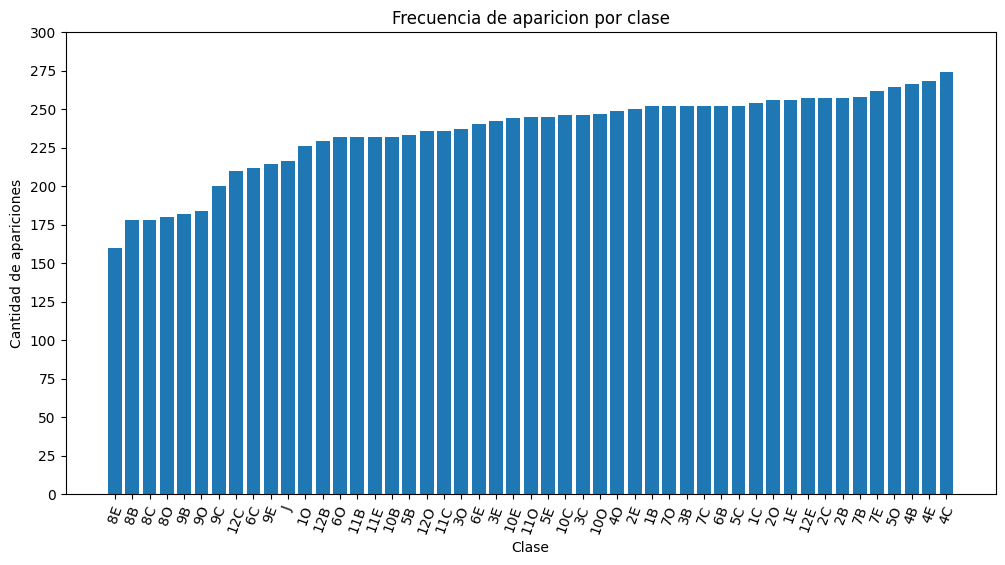

In [ ]:
# Graficamos
plt.figure(figsize=(12,6))
plt.bar(x='clase', height='frecuencia_absoluta', data=tabla_conteo_clases)
plt.xlabel('Clase')
plt.ylabel('Cantidad de apariciones')
plt.yticks(ticks=np.arange(0, 301, 25))
plt.xticks(rotation=70)
plt.title('Frecuencia de aparicion por clase')
plt.show()

* Observando las medidas resumen de las frecuencias relativas vemos que todas las clases con tienen en proporcion entre el 1.39% y 2.38% del total. En terminos absolutos estamos hablando entre 160 y 274 apariciones por clase.

* A simple vista lo anterior no parece un gran desbalanceo.

* La carta mas frecuente es el 4 de copas y la menos frecuente el 8 de espada.

### Visualizacion del dataset con fiftyone

In [ ]:
# Nombre único para el dataset
name = "dataset_yolo_tp"

# Ruta al directorio del dataset
dataset_dir = "/content/drive/MyDrive/TUIA_Computer_Vision/TP_02/data"

# Las particiones a cargar
splits = ["train", "val", "test"]

# Crear y cargar el dataset, usando tags para marcar las muestras en cada partición
dataset = fo.Dataset(name)
for split in splits:
    dataset.add_dir(
        dataset_dir=dataset_dir,
        dataset_type=fo.types.YOLOv5Dataset,
        split=split,
        tags=split,
    )

# # Ver información resumida sobre el dataset
# print(dataset)

# # Imprimir las primeras muestras en el dataset
# print(dataset.head())

# Lanzar la aplicación FiftyOne para visualizar el dataset
session = fo.launch_app(dataset)


Migrating database to v0.24.1


INFO:fiftyone.migrations.runner:Migrating database to v0.24.1


 100% |███████████████| 1914/1914 [17.1m elapsed, 0s remaining, 1.9 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 1914/1914 [17.1m elapsed, 0s remaining, 1.9 samples/s]      


 100% |█████████████████| 205/205 [1.9m elapsed, 0s remaining, 2.0 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 205/205 [1.9m elapsed, 0s remaining, 2.0 samples/s]      


 100% |█████████████████| 206/206 [1.8m elapsed, 0s remaining, 2.1 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 206/206 [1.8m elapsed, 0s remaining, 2.1 samples/s]      



Welcome to

███████╗██╗███████╗████████╗██╗   ██╗ ██████╗ ███╗   ██╗███████╗
██╔════╝██║██╔════╝╚══██╔══╝╚██╗ ██╔╝██╔═══██╗████╗  ██║██╔════╝
█████╗  ██║█████╗     ██║    ╚████╔╝ ██║   ██║██╔██╗ ██║█████╗
██╔══╝  ██║██╔══╝     ██║     ╚██╔╝  ██║   ██║██║╚██╗██║██╔══╝
██║     ██║██║        ██║      ██║   ╚██████╔╝██║ ╚████║███████╗
╚═╝     ╚═╝╚═╝        ╚═╝      ╚═╝    ╚═════╝ ╚═╝  ╚═══╝╚══════╝ v0.24.1

If you're finding FiftyOne helpful, here's how you can get involved:

|
|  ⭐⭐⭐ Give the project a star on GitHub ⭐⭐⭐
|  https://github.com/voxel51/fiftyone
|
|  🚀🚀🚀 Join the FiftyOne Slack community 🚀🚀🚀
|  https://slack.voxel51.com
|



INFO:fiftyone.core.session.session:
Welcome to

███████╗██╗███████╗████████╗██╗   ██╗ ██████╗ ███╗   ██╗███████╗
██╔════╝██║██╔════╝╚══██╔══╝╚██╗ ██╔╝██╔═══██╗████╗  ██║██╔════╝
█████╗  ██║█████╗     ██║    ╚████╔╝ ██║   ██║██╔██╗ ██║█████╗
██╔══╝  ██║██╔══╝     ██║     ╚██╔╝  ██║   ██║██║╚██╗██║██╔══╝
██║     ██║██║        ██║      ██║   ╚██████╔╝██║ ╚████║███████╗
╚═╝     ╚═╝╚═╝        ╚═╝      ╚═╝    ╚═════╝ ╚═╝  ╚═══╝╚══════╝ v0.24.1

If you're finding FiftyOne helpful, here's how you can get involved:

|
|  ⭐⭐⭐ Give the project a star on GitHub ⭐⭐⭐
|  https://github.com/voxel51/fiftyone
|
|  🚀🚀🚀 Join the FiftyOne Slack community 🚀🚀🚀
|  https://slack.voxel51.com
|



### Nueva aumentacion luego del primer entrenamiento

* A esta altura del trabajo ya se intento entrenar el primer modelo en una notebook de Kaggle haciendo una aumentacion de 1 imagen por cada imagen del dataset de train. Lo que se intentara para mejorar las metricas es aumentar una mas por cada imagen (es decir por cada imagen nos quedan 2 imagenes aumentadas).

* Debido a que trabajamos con Drive y Colab para esta etapa y Drive nos proporciona un almacenamiento de 15gb y tenemos ocupados 12.64 solo aumentando una vez cada imagen de train vamos a tener que eliminar las primeras aumentaciones para generar espacio, generar las segundas y juntar todo en nuestra pc local para subirlo luego a un dataset Kaggle y entrenar desde una notebook Kaggle.

* En principio solo se eliminaran las imagenes aumentadas de la primera aumentacion y los txt con los bb se dejaran con el objetivo de luego sumar los nuevos y poder hacer un nuevo analisis del balanceo de clases (ya que solo necesitamos los txt).

* Las nuevas imagenes se descargaran manualmente y se juntara todo en las carpetas correspondientes para subir a Kaggle.

In [ ]:
# Ruta a donde se encuentran las instancias de entrenamiento
ruta_img_train = '/content/drive/MyDrive/TUIA_Computer_Vision/TP_02/data/images/train'

# Ruta a los labels de Train
ruta_labels_train = '/content/drive/MyDrive/TUIA_Computer_Vision/TP_02/data/labels/train'

#### Eliminar imagenes aumentadas

In [ ]:
# Obtenemos los nombres de las imagenes aumentadas
nombre_imagenes_aumentadas = [ img for img in os.listdir(ruta_img_train) if 'aumentada' in img]

for img in nombre_imagenes_aumentadas:

  # Creamos la ruta
  ruta_imagen_aumentada = os.path.join(ruta_img_train, img)

  # Si existe
  if os.path.exists(ruta_imagen_aumentada):
    # Lo borramos
    os.remove(ruta_imagen_aumentada)

* Incialmente teniamos 957 imagenes de train.

* Aumentamos a luego a 1914 en total.

In [ ]:
print('-----'*7)
print('Train:')
print('-----'*7)
print(f'Cantidad de imagenes: {len(os.listdir(ruta_img_train))}')
print('-----'*7)

-----------------------------------
Train:
-----------------------------------
Cantidad de imagenes: 957
-----------------------------------


In [ ]:
nombre_imagenes = [ img for img in os.listdir(ruta_img_train) ]
nombre_imagenes[:10]

['058.jpg',
 '059.jpg',
 '063.jpg',
 '061.jpg',
 '064.jpg',
 '065.jpg',
 '067.jpg',
 '066.jpg',
 '069.jpg',
 '071.jpg']

* Como podemos ver volvemos a tener las imagenes sin aumentar. Ahora que tenemos espacio podemos generar la segunda aumentacion.

#### Nueva aumentacion:

Creamos nuevos directorios para no mezclarlos

In [ ]:
# Directorios donde guardaremos las nuevas imagenes y los labels
nuevo_directorio = '/content/drive/MyDrive/TUIA_Computer_Vision/TP_02/imagenes_aumentadas_02'
nuevo_directorio_img = os.path.join(nuevo_directorio, 'images')
nuevo_directorio_label = os.path.join(nuevo_directorio, 'labels')

for directorio in [nuevo_directorio, nuevo_directorio_img, nuevo_directorio_label]:
  if not os.path.exists(directorio):
    os.makedirs(directorio)

Generamos la aumentacion

In [ ]:
# Por cada imagen
for img in sorted(nombre_imagenes):

  # Cargar las imagenes
  imagen = cv2.imread( os.path.join(ruta_img_train, img) )
  # Convertir a RGB ya que albumentations trabaja con RGB
  imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)

  # Extraccion de anotaciones en formato Albumentations
  # Aqui guardaremos los bboxes con el formato que necesita Albumentations, para yolo: (x_center, y_center, w, h, class)
  bb_imagen_albumentations = []

  # Abrimos el archivo y nos quedamos con cada linea (anotacion de objeto)
  with open( os.path.join(ruta_labels_train, os.path.splitext(img)[0] + ".txt") , 'r') as file:
      lineas = file.readlines()

  # Recorremos cada linea
  for linea in lineas:
    # Extraemos en una lista cada una de sus componentes
    items_linea = linea.strip().split()
    # Extraemos el primer elemento (clase) y la convertimos a entero
    clase = int(items_linea.pop(0))
    # Convertimos a float el resto de coordenadas
    items_linea = [float(x) for x in items_linea]
    # Agregamos en ultima posicion la clase
    items_linea.append(clase)
    # Agregamos la anotacion a una lista de anotaciones
    bb_imagen_albumentations.append(items_linea)

  # Transformamos la imagen
  transformacion = transform(image=imagen, bboxes=bb_imagen_albumentations)

  # Obtenemos los resultados
  imagen_aumentada = cv2.cvtColor(transformacion['image'], cv2.COLOR_BGR2RGB)
  bboxes_aumentados = transformacion['bboxes']
  # Pasamos las tuplas a lista (solo para graficar con la funcion anterior)
  bboxes_aumentados = [list(bbox) for bbox in bboxes_aumentados]

  nombre_imagen_aumentada = os.path.splitext(img)[0] + '_aumentada_02' + os.path.splitext(img)[1]

  nombre_txt_aumentado = os.path.splitext(img)[0] + '_aumentada_02.txt'

  # Guardamos la imagen
  cv2.imwrite( os.path.join(nuevo_directorio_img, nombre_imagen_aumentada) , imagen_aumentada)

  # Modificamos la estructura de bbox/clase que devuelve Albumentations para que quede clase/bbox en formato yolo
  bboxes_aumentados_yolo = []
  for bbox in copy.deepcopy(bboxes_aumentados):
    clase = bbox.pop()
    bbox.insert(0, clase)
    bbox = [str(x) for x in bbox]
    bboxes_aumentados_yolo.append(bbox)

  # Guardamos los bboxes en un .txt
  bbox_str = ''
  with open( os.path.join(nuevo_directorio_label, nombre_txt_aumentado) , 'w') as f:
      for i, bbox in enumerate(bboxes_aumentados_yolo):
          bbox_str += ' '.join(bbox)
          if i != (len(bboxes_aumentados_yolo)-1): bbox_str += '\n'
      f.write(bbox_str)

Verificamos la cantidad de imagenes generadas

In [ ]:
print('-----'*7)
print('Aumentadas 2:')
print('-----'*7)
print(f'Cantidad de imagenes: {len(os.listdir(nuevo_directorio_img))}')
print(f'Cantidad de labels: {len(os.listdir(nuevo_directorio_label))}')
print('-----'*7)

-----------------------------------
Aumentadas 2:
-----------------------------------
Cantidad de imagenes: 957
Cantidad de labels: 957
-----------------------------------


* Se genero la cantidad deseada.

#### Graficamos de nuevo para corroborar que se hayan generado bien.

Usamos las funciones generadas mas arriba y modificamos esta para que tome la nueva ruta de las nuevas imagenes aumentadas y sus labels.

In [ ]:
# Mezclamos para imprimir aleatoriamente las primeras n
random.shuffle(nombre_imagenes)

n=10

# Imprimimos los primeros n pares
for img in nombre_imagenes[:n]:
  graficar_imagenes(nombre_img=img, diccionario_clases=diccionario_clases, sufijo='_aumentada_02', ruta_img=nuevo_directorio_img, ruta_labels=nuevo_directorio_label)

Output hidden; open in https://colab.research.google.com to view.

* Nuevamente las aumentaciones parecen haber salido bien.

#### Composicion del nuevo dataset.

* Primero movemos las etiquetas del nuevo dataset aumentado a donde estan todas las otras para ver el balanceo del dataset completo.

In [ ]:
nombre_labels_aumentados_2 = [label for label in os.listdir(nuevo_directorio_label)]

for label in nombre_labels_aumentados_2:

  ruta_label = os.path.join(nuevo_directorio_label, label)
  nueva_ruta = os.path.join(ruta_labels_train, label)

  if os.path.exists(ruta_label):

    shutil.move(ruta_label, nueva_ruta)

In [ ]:
print(f'Cantidad de labels: {len(os.listdir(ruta_labels_train))}')

Cantidad de imagenes: 2871


* Tenemos 2871 labels lo cual es correcto

##### Nuevo conteo de clases

In [ ]:
# Diccionario donde contaremos la cantidad de instancias por clases en todo el dataset
conteo_clases = {indice: 0 for indice, clase in enumerate(clases.split())}

nombre_labels = [label for label in os.listdir(ruta_labels_train)]

for label in nombre_labels:

  # Abrimos el archivo y nos quedamos con cada linea (anotacion de objeto)
  with open( os.path.join(ruta_labels_train, label) , 'r') as file:
      lineas = file.readlines()

  # Recorremos cada linea
  for linea in lineas:
    # Extraemos en una lista cada una de sus componentes
    items_linea = linea.strip().split()
    # Extraemos el primer elemento (clase) y la convertimos a entero
    clase = int(items_linea.pop(0))

    conteo_clases[clase] += 1

##### Tabla con frecuencias de aparicion por clase

In [ ]:
tabla_conteo_clases = pd.DataFrame(data={'clase': clases.split(), 'frecuencia_absoluta': conteo_clases.values()})
tabla_conteo_clases['frecuencia_relativa'] = round(( tabla_conteo_clases['frecuencia_absoluta'] * 100 ) / tabla_conteo_clases['frecuencia_absoluta'].sum(), 2)
tabla_conteo_clases = tabla_conteo_clases.sort_values(by='frecuencia_absoluta') # Ordenamos de menor a mayor
tabla_conteo_clases

,clase,frecuencia_absoluta,frecuencia_relativa
30,8E,240,1.39
31,8B,267,1.54
29,8C,267,1.54
28,8O,270,1.56
35,9B,273,1.58
32,9O,276,1.60
33,9C,300,1.73
45,12C,315,1.82
21,6C,317,1.83
34,9E,321,1.86


In [ ]:
tabla_conteo_clases.describe()

,frecuencia_absoluta,frecuencia_relativa
count,49.000000,49.000000
mean,352.918367,2.041224
std,40.551838,0.235174
min,240.000000,1.390000
25%,344.000000,1.990000
50%,368.000000,2.130000
75%,378.000000,2.190000
max,411.000000,2.380000


In [ ]:
print(f"Cantidad de cartas en total: {tabla_conteo_clases['frecuencia_absoluta'].sum()}")

Cantidad de cartas en total: 17293


##### Grafico de barra de frecuencia de aparicion:

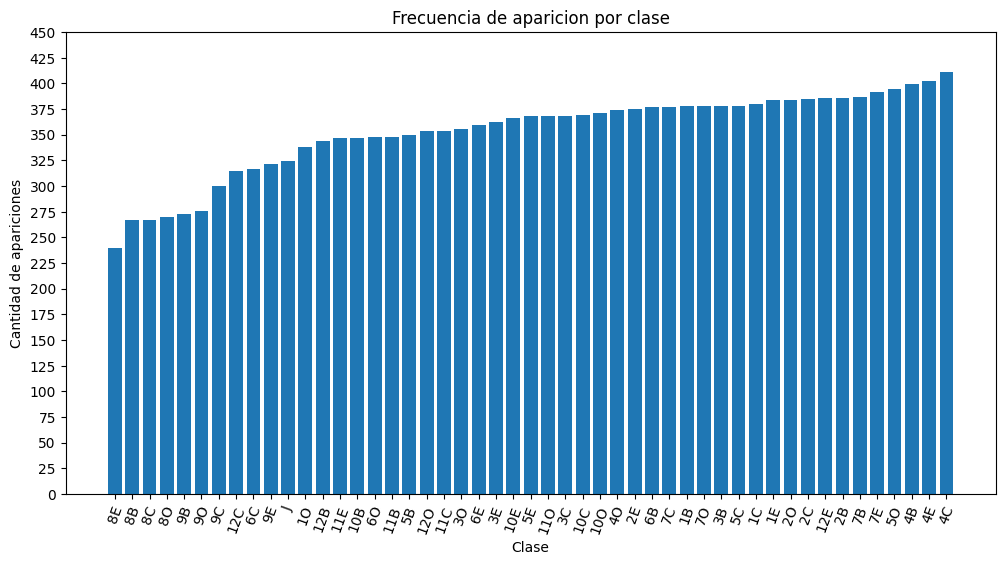

In [ ]:
# Graficamos
plt.figure(figsize=(12,6))
plt.bar(x='clase', height='frecuencia_absoluta', data=tabla_conteo_clases)
plt.xlabel('Clase')
plt.ylabel('Cantidad de apariciones')
plt.yticks(ticks=np.arange(0, 451, 25))
plt.xticks(rotation=70)
plt.title('Frecuencia de aparicion por clase')
plt.show()

* Se mantiene la relacion anterior en terminos relativos. Continua bastante balanceado.

* Con este nuevo dataset vamos a probar entrenar un modelo pre-entrenado con mas parametros a ver que resultados da.